# This Jupyter notebook collects user comments on LinkedIn posts in which the desired company is tagged, and uses natural language processing to provide a brief sentiment analysis for those comments.

In [2]:
import pandas as pd
import numpy as np

from getpass import getpass
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import time

import matplotlib.pyplot as plt
import seaborn as sns

## Scraping Data from Linkedin

#### Autentication

In [ ]:
username = input("USERNAME: ")
password = getpass("PASSWORD: ")

#### Company Search

In [ ]:
company = input("COMPANY: ")

#### Login

In [ ]:
driver = webdriver.Chrome()
driver.get('https://www.linkedin.com')
username_field = driver.find_element(By.ID, 'session_key')
password_field = driver.find_element(By.ID, 'session_password')
username_field.send_keys(username)
password_field.send_keys(password)
password_field.send_keys(Keys.ENTER)

In [ ]:
# Go to Linkedin company page
search_bar = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="global-nav-typeahead"]/input')))
search_bar.send_keys(company)
search_bar.send_keys(Keys.ENTER)

# Go to post section
time.sleep(5)
posts_section = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="search-reusables__filters-bar"]/ul/li[1]/button')))
posts_section.send_keys(Keys.ENTER)


#### Scraper

In [ ]:
# Scroll function
def scroll_to_bottom():
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)
        
# Click on "Carica altri commenti" buttons functions
def click_load_more_comments():
    load_more_comments_buttons = driver.find_elements(By.XPATH, "//span[@class='artdeco-button__text' and text()='Carica altri commenti']")
    for button in load_more_comments_buttons:
        driver.execute_script("arguments[0].click();", button)
        time.sleep(2)

# Take comments function
def get_comments():
    new_comments = driver.find_elements(By.XPATH, "//span[@dir='ltr']")
    updated_comments = []
    for comment in new_comments:
        updated_comments.append(comment.text)
    return updated_comments

all_comments = []

In [ ]:
start_time = time.time() # Scroll Start time
total_time = 400 # Total scoll time in sec.

while True:
    scroll_to_bottom()
    elapsed_time = time.time() - start_time
    if elapsed_time >= total_time:
        break
click_load_more_comments()
time.sleep(60)
get_comments()

all_comments = get_comments()

#### DataFrame

In [10]:
# all_comments.to_csv('BendingSpoons.csv', index=False)
#comments_raw=pd.read_csv('BendingSpoons.csv')

In [11]:
comments_raw=pd.DataFrame(comments_raw)
comments=comments_raw.copy()
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2156 entries, 0 to 2155
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Comments  2156 non-null   object
dtypes: object(1)
memory usage: 17.0+ KB


In [12]:
comments.isnull().sum()

Comments    0
dtype: int64

In [13]:
comments.head(5)

,Comments
0,«lo spooner può prendersi tutto il tempo di cu...
1,"permessi illimitati, stipendio pieno e doppio ..."
2,repubblica.it • 3 min di lettura
3,"andrea crocco un buon inglese, bravo. ma non c..."
4,ma quand'è che questo posto è diventato il nuo...


## Dtaset Cleaning

In [14]:
comments = comments.rename(columns={"0":"Comments"})

comments["Comments"] = comments["Comments"].str.lower()

comments=comments.dropna()

filtro = comments["Comments"].str.contains("visualizza il profilo di")
comments = comments[~filtro].reset_index(drop=True)

comments.sample(10)

,Comments
308,bravi davvero..
1665,tra le aziende outlier del network endeavor ne...
1854,well done!! 👏👏👏
2059,congrats cimer!
1880,marion creach
836,"when people ask me what i do for a living, and..."
106,entrepreneur companies
265,"ancora non mi sembra vero, ma oggi è stato il ..."
2146,maria-diana dutica you’re welcome ☺️
946,great work!


## English Translation and Country Detection

In [15]:
from deep_translator import GoogleTranslator
import langdetect

In [16]:
# Language detect function
def detect_language(text):
    try:
        lang = langdetect.detect(text)
    except:
        lang = 'unknown'
    return lang

# Translation function
def translate_to_english(text):
    translator = GoogleTranslator(source='auto', target='en')
    text = translator.translate(text)
    return text

comments['Comments_eng'] = comments.apply(lambda x: translate_to_english(x['Comments']) if detect_language(x['Comments']) != 'en' else x['Comments'], axis=1)
comments['Country'] = comments.apply(lambda x: detect_language(x['Comments']), axis=1)

In [28]:
comments.sample(3)

,Comments,Comments_eng,Country
1252,interested. having 8 years of experience as fr...,interested. having 8 years of experience as fr...,en
1651,alessia di iacovo,alessia di iacovo,it
1446,how to apply?,how to apply?,en


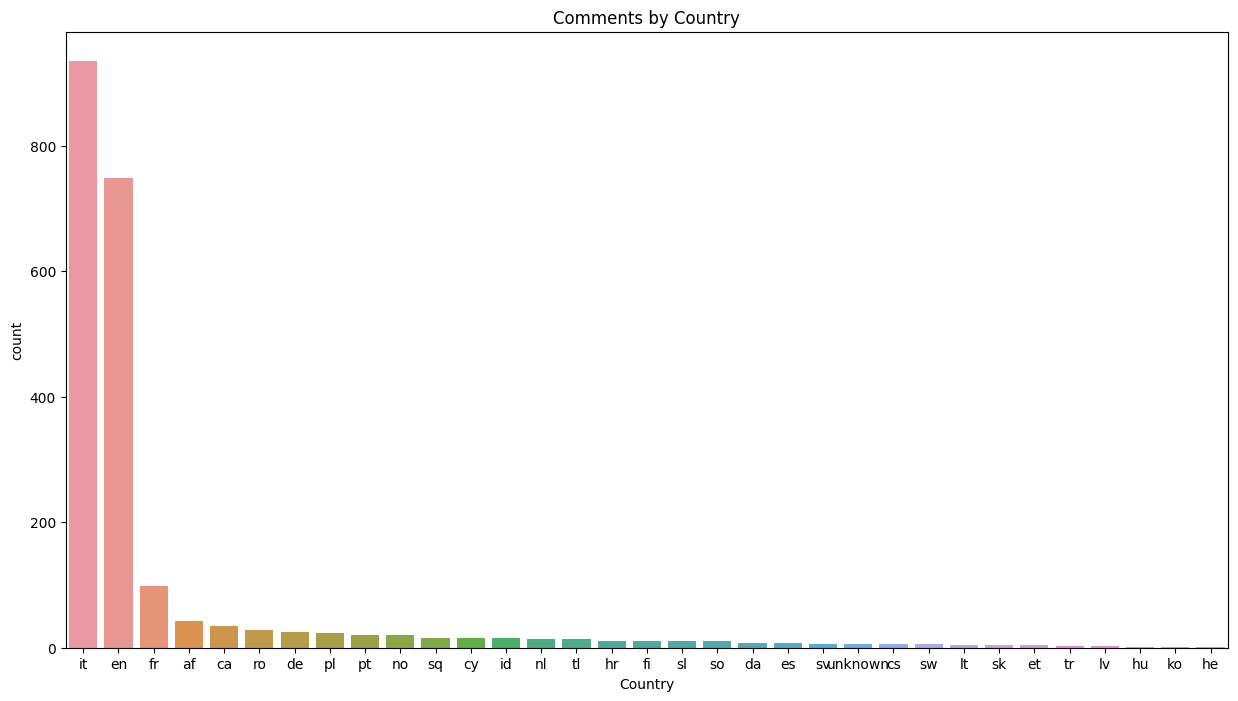

In [29]:
plt.figure(figsize=(15, 8))
sns.countplot(x='Country', data=comments, order=comments['Country'].value_counts().index)
plt.title('Comments by Country')
plt.show()

In [30]:
comments[comments['Country'] == 'unknown']

,Comments,Comments_eng,Country
320,https://www.techcompany360.it/tech-company/ecc...,https://www.techcompany360.it/tech-company/ecc...,unknown
469,https://bestworkplaces.economist.com/,https://bestworkplaces.economist.com/,unknown
1250,+1,+1,unknown
1503,👉 https://open.spotify.com/episode/0tmco12hbub...,👉 https://open.spotify.com/episode/0tmco12hbub...,unknown
1828,https://www.thefastcode.com/de-eur/article/how...,https://www.thefastcode.com/de-eur/article/how...,unknown
2004,📣 𝗣𝘂𝗿𝗰𝗵𝗮𝘀𝗲𝗹𝘆 𝗧𝗮𝗸𝗲𝗮𝘄𝗮𝘆𝘀 - 𝘁𝗵𝗲 𝗹𝗮𝘁𝗲𝘀𝘁 𝗜𝗻-𝗔𝗽𝗽 𝗦𝘂𝗯...,📣 𝗣𝘂𝗿𝗰𝗵𝗮𝘀𝗲𝗹𝘆 𝗧𝗮𝗸𝗲𝗮𝘄𝗮𝘆𝘀 - 𝘁𝗵𝗲 𝗹𝗮𝘁𝗲𝘀𝘁 𝗜𝗻-𝗔𝗽𝗽 𝗦𝘂𝗯...,unknown


## Removing records containing only personal names using Natural Language Processing

In [18]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [19]:
def remove_name_only_rows(text):
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ == "PERSON" and len(text.split()) <= 2:
            return True
    return False

comments_only_names = comments[comments['Comments_eng'].apply(remove_name_only_rows)]

In [23]:
comments = comments[~comments['Comments_eng'].isin(comments_only_names['Comments_eng'])]

In [ ]:
#comments.to_csv("BendingSpoons.csv")

## Brief Sentiment Ananlysis using a pretrained model based on BERT from Huggingface


In [ ]:
comments = pd.read_csv("C:/Users/Lavoro/Desktop/Linkedin Sentiment/BendingSpoons.csv")
comments.info()

In [25]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2156 entries, 0 to 2155
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Comments      2156 non-null   object
 1   Comments_eng  2156 non-null   object
 2   Country       2156 non-null   object
dtypes: object(3)
memory usage: 67.4+ KB


In [24]:
comments.sample(5)

,Comments,Comments_eng,Country
1201,lorenzo colucci ?,lorenzo colucci,it
1806,seit 2011 nutze ich evernote. 66.000 „notizen“...,"I've been using evernote since 2011. 66,000 ""n...",de
1327,great 🔥,great 🔥,ro
158,vanityfair.it • 3 min di lettura,vanityfair.it • 3 min read,fi
807,congrats pietro!!,congrats pietro!!,it


In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
sentiment = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, max_length = 511)

c:\Users\Lavoro\anaconda3\envs\boolean\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lavoro\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
# Test
sentiment("some time i like play football")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[{'label': 'positive', 'score': 0.6572840213775635}]

In [31]:
# Function to apply the sentiment pipeline
def get_sentiment(comment):
    result = sentiment(comment)[0]
    return result['label']

# apply the sentiment pipeline to each comment in the 'Comments_eng' column
comments['Sentiment'] = comments['Comments_eng'].apply(get_sentiment)

In [32]:
comments.sample(5)

,Comments,Comments_eng,Country,Sentiment
531,"da quel che ho capito leggendo su hacker news,...","from what I understand reading on hacker news,...",it,neutral
511,ma come si fa a parlare di unicorni in italia ...,but how can you talk about unicorns in italy i...,it,neutral
91,"matteo moscarelli i am interested, thank you!","matteo moscarelli i am interested, thank you!",en,positive
1299,milano & partners,milano & partners,tl,neutral
1528,grazie!,Thank you!,pl,positive


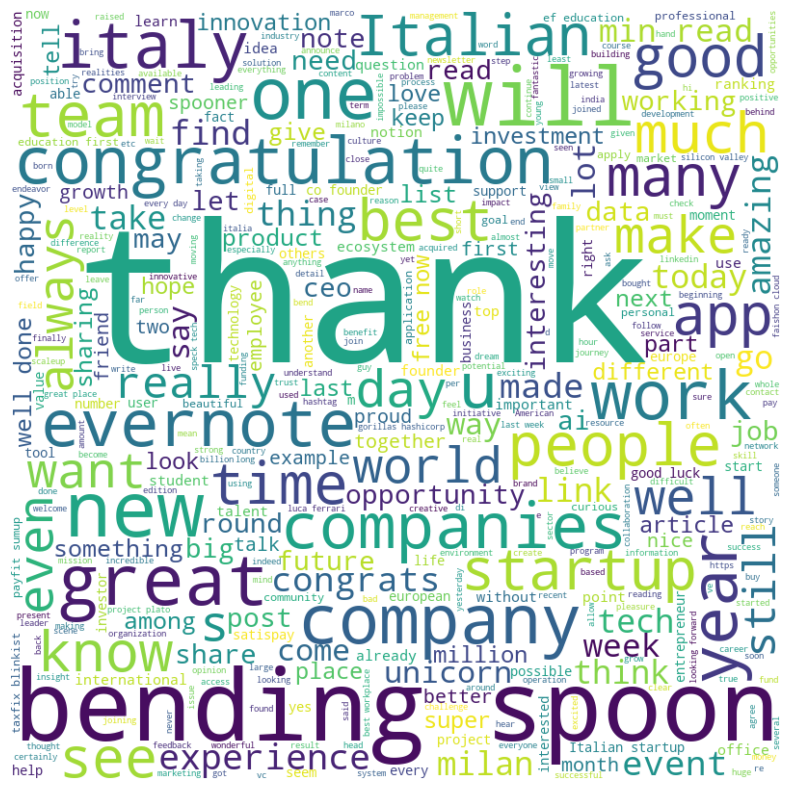

In [45]:
from wordcloud import WordCloud
  
text = " ".join(comment for comment in comments["Comments_eng"])
plt.figure(figsize=(20, 10))  
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=400, max_font_size=200)
wordcloud.generate(text)
                                                                        
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


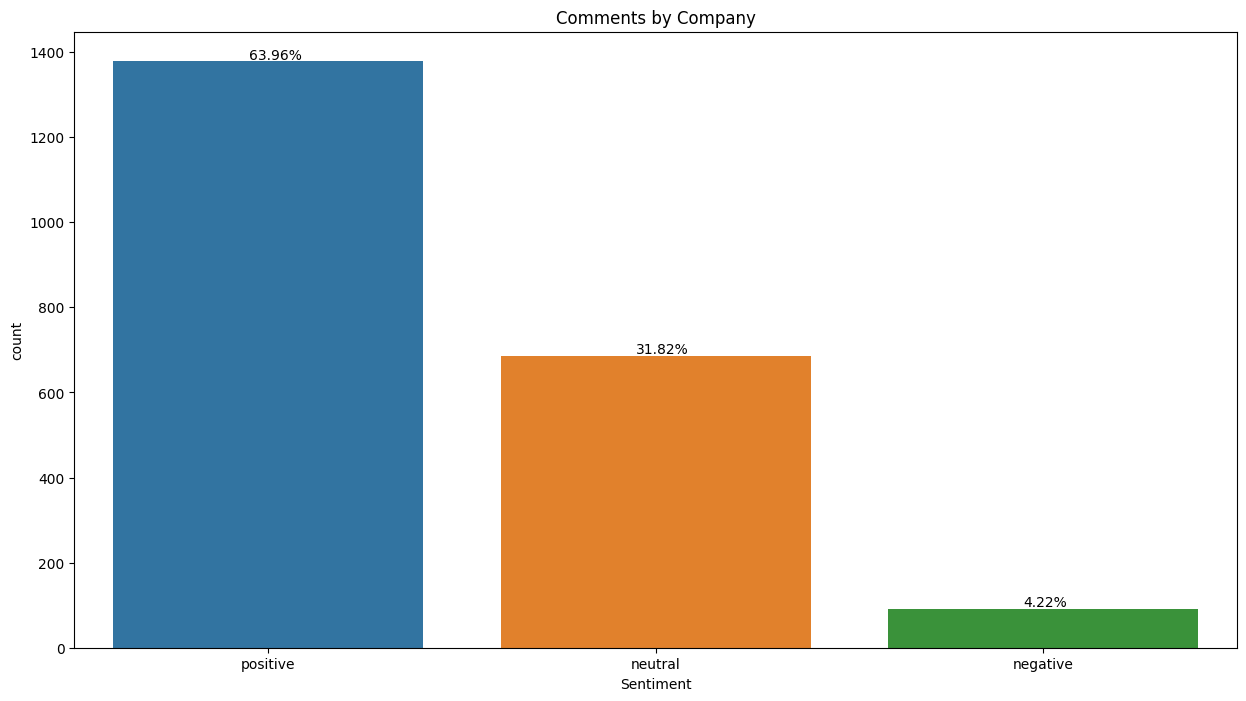

In [65]:
#voglio le percentuali più centrate
plt.figure(figsize=(15, 8))
ax = sns.countplot(x='Sentiment', data=comments, order=comments['Sentiment'].value_counts(normalize=True).index)
plt.title('Comments by Company')
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()*100/len(comments)), (p.get_x()+0.35, p.get_height()+5))
plt.show()


In [ ]:

sentiment_counts = comments['Sentiment'].value_counts(normalize=True)

fig, ax = plt.subplots()

bars = ax.bar(sentiment_counts.index, sentiment_counts.values)

ax.set_xlabel("Sentiment")
ax.set_ylabel("Comments %")

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.0%}', xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.show()


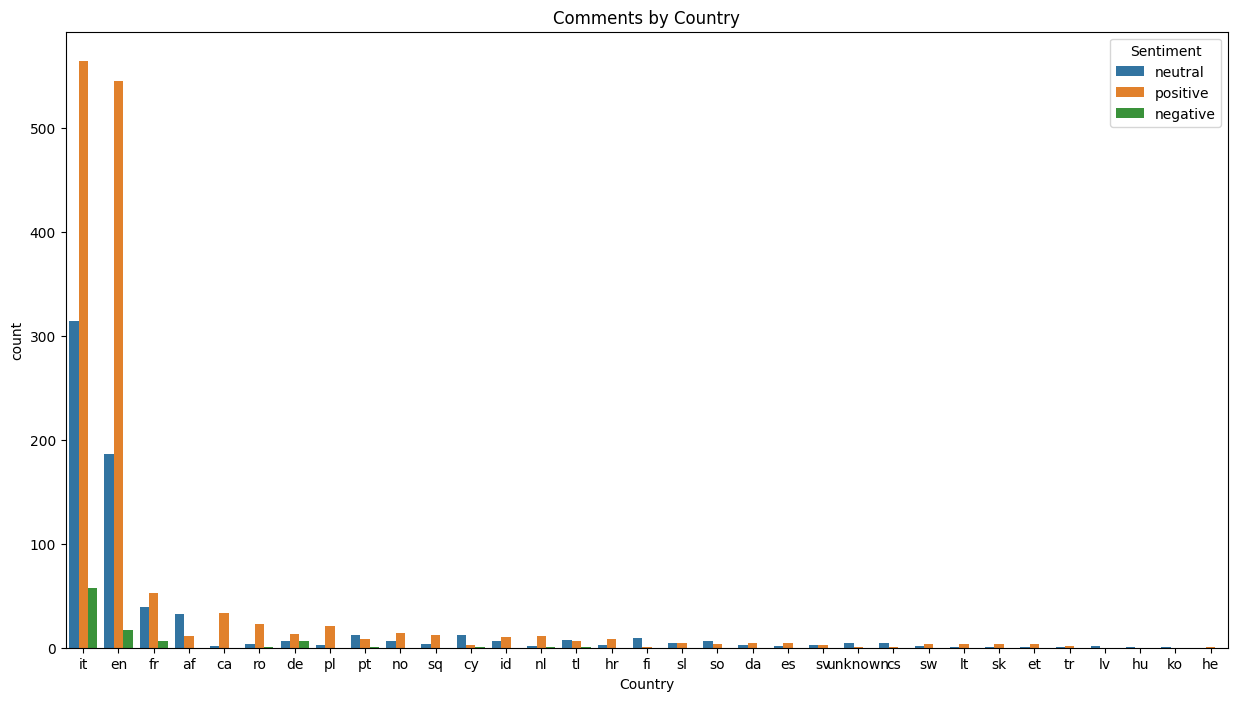

In [47]:
plt.figure(figsize=(15, 8))
sns.countplot(x='Country', data=comments, hue='Sentiment', order=comments['Country'].value_counts().index)
plt.title('Comments by Country')
plt.show()